# Analyse Chainer CIFAR100 performance at cuda.py

### Inspect log files

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [176]:
!ls *.log

chainer_timings_K80_b128e1.log
chainer_timings_k80_b64e1.log
chainer_timings_mouse_b128e1.log
chainer_timings_mouse_b64e1.log
chainer_timings_mouse_convert_b128e1.log
chainer_timings_mouse_convert_b64e1.log
chainer_timings_mouse_cuda_b64e1.log


In [200]:
filename="chainer_timings_mouse_convert_b32e1.log"
print "Reading",filename
log_data = pd.read_csv(filename,header=[0], skiprows=[0])
log_data.iloc[:5]

Reading chainer_timings_mouse_convert_b32e1.log


,Address,Parameter,Value
0,convert.py/to_device,x.nbytes,393216
1,convert.py/to_device_393216,x.shape,(32: 3: 32: 32)
2,convert.py/to_device_393216,point1_delta (s),0.001114
3,convert.py/to_device_393216,point1_delta2(s),0.001118
4,convert.py/to_device,x.nbytes,128


In [201]:
def my_replace(s):
    s = str.replace(s,"convert.py/to_device_","")
    return s

def replaceString(df, column):
    return pd.concat([df.drop(column, axis=1), df[column].apply(my_replace)], axis=1)

In [202]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    if type(s) is not str:
        print type(s)
        return None
    global pat
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [203]:
def apply_inplace(df, field, fun):
    return pd.concat([df.drop(field, axis=1), df[field].apply(fun)], axis=1) 

In [204]:
log_addr = replaceString(log_data, "Address")
log_addr.iloc[:5]

,Parameter,Value,Address
0,x.nbytes,393216,convert.py/to_device
1,x.shape,(32: 3: 32: 32),393216
2,point1_delta (s),0.001114,393216
3,point1_delta2(s),0.001118,393216
4,x.nbytes,128,convert.py/to_device


In [205]:
times = log_addr[log_addr["Parameter"].str.contains("point1_delta")]
times.iloc[:5]

,Parameter,Value,Address
2,point1_delta (s),0.001114,393216
3,point1_delta2(s),0.001118,393216
6,point1_delta (s),0.000420,128
7,point1_delta2(s),0.000421,128
10,point1_delta (s),0.000350,393216


In [206]:
times.loc[:,"Value"] = times.loc[:,"Value"].apply(parseFloat)
times.loc[:,"Address"] = times.loc[:,"Address"].apply(parseFloat)
print times.Address.unique()
times.iloc[:15]

[  3.93216000e+05   1.28000000e+02   1.96608000e+05   6.40000000e+01]


,Parameter,Value,Address
2,point1_delta (s),0.001114,393216.0
3,point1_delta2(s),0.001118,393216.0
6,point1_delta (s),0.000420,128.0
7,point1_delta2(s),0.000421,128.0
10,point1_delta (s),0.000350,393216.0
11,point1_delta2(s),0.000353,393216.0
14,point1_delta (s),0.000122,128.0
15,point1_delta2(s),0.000122,128.0
18,point1_delta (s),0.000276,393216.0
19,point1_delta2(s),0.000282,393216.0


## Количество вызовов для каждого размера массива

In [207]:
grouped = times.groupby("Address")

In [208]:
print grouped["Value"].count()

Address
64.0           2
128.0       3750
196608.0       2
393216.0    3750
Name: Value, dtype: int64


In [209]:
print grouped["Value"].sum()

Address
64.0          0.000265
128.0         0.560085
196608.0      0.010498
393216.0    144.615924
Name: Value, dtype: float64


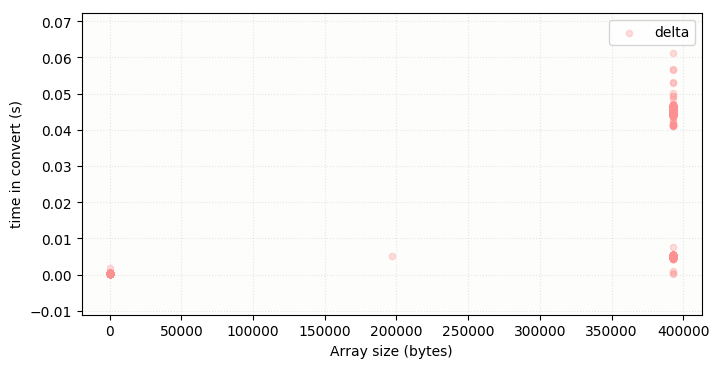

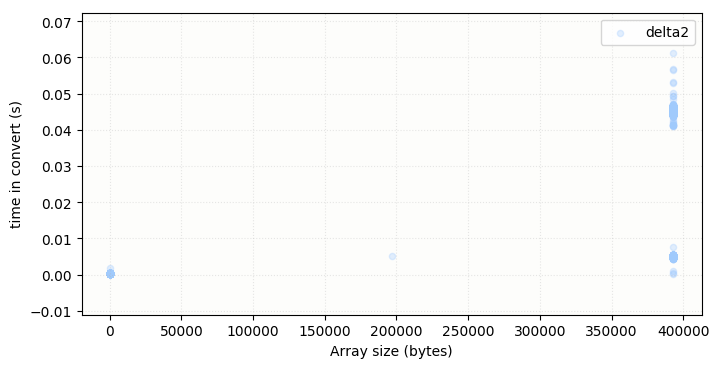

In [210]:
ax = times.loc[times["Parameter"]=="point1_delta (s)"].plot.scatter(x="Address",y="Value",figsize=(8,4),label="delta",color="#ff9090",alpha=0.3)
ax2 = times.loc[times["Parameter"]=="point1_delta2(s)"].plot.scatter(x="Address",y="Value",figsize=(8,4),label="delta2",color = '#a0caff',alpha=0.3)
def format_ax(ax):
    ax.set_facecolor("#fdfdfb")
    ax.set_ylabel("time in convert (s)")
    ax.grid('on', alpha=0.3, ls=":" )
    ax.set_xlabel("Array size (bytes)")
    
format_ax(ax)
format_ax(ax2)

In [74]:
data1=log_data.copy()
print data1["Parameter"].unique()

[' Array type' 'array_dev.id' 'cupy.cuda.device.get_device_id()'
 'array.dtype' 'array.shape' 'array.size' 'array.itemsize' 'array.nbytes'
 'point1_delta (s)' 'point2_delta (s)' 'cupy_arr type' 'point3_delta (s)'
 ' x type']


In [75]:
# Какие типы имеет параметр array
array_type = data1[data1["Parameter"] == " Array type"]
print array_type.shape
print array_type.Value.unique()
array_type.iloc[:3]

(1962, 3)
[" <type 'numpy.ndarray'>"]


,Address,Parameter,Value
0,cuda.py/_array_to_gpu,Array type,<type 'numpy.ndarray'>
12,cuda.py/_array_to_gpu,Array type,<type 'numpy.ndarray'>
24,cuda.py/_array_to_gpu,Array type,<type 'numpy.ndarray'>


In [76]:
# Какие типы значения принимают параметры array_dev.id и cupy...device_id()
device_id = data1[data1["Parameter"] == "array_dev.id"]
cuda_device = data1[data1["Parameter"] == "cupy.cuda.device.get_device_id()"]
print device_id.shape
print device_id.Value.unique()
print cuda_device.shape
print cuda_device.Value.unique()

(1962, 3)
['-1']
(1962, 3)
['0']


In [82]:
data1["Address"].unique()

array(['cuda.py/_array_to_gpu', 'cuda.py/_array_to_gpu:310',
       'cuda.py/_array_to_gpu:310(512:)',
       'cuda.py/_array_to_gpu:340(512:)',
       'cuda.py/_array_to_gpu:360(512:)', 'cuda.py/_array_to_gpu:310(64:)',
       'cuda.py/_array_to_gpu:340(64:)', 'cuda.py/_array_to_gpu:360(64:)',
       'cuda.py/_array_to_gpu:310(256:)',
       'cuda.py/_array_to_gpu:340(256:)',
       'cuda.py/_array_to_gpu:360(256:)',
       'cuda.py/_array_to_gpu:310(128:)',
       'cuda.py/_array_to_gpu:340(128:)',
       'cuda.py/_array_to_gpu:360(128:)',
       'cuda.py/_array_to_gpu:310(64: 3: 32: 32)',
       'cuda.py/_array_to_gpu:340(64: 3: 32: 32)',
       'cuda.py/_array_to_gpu:360(64: 3: 32: 32)', 'convert.py/to_device',
       'cuda.py/_array_to_gpu:310(16: 3: 32: 32)',
       'cuda.py/_array_to_gpu:340(16: 3: 32: 32)',
       'cuda.py/_array_to_gpu:360(16: 3: 32: 32)',
       'cuda.py/_array_to_gpu:310(16:)', 'cuda.py/_array_to_gpu:340(16:)',
       'cuda.py/_array_to_gpu:360(16:)'], dtype

In [83]:
data1["Parameter"].unique()

array([' Array type', 'array_dev.id', 'cupy.cuda.device.get_device_id()',
       'array.dtype', 'array.shape', 'array.size', 'array.itemsize',
       'array.nbytes', 'point1_delta (s)', 'point2_delta (s)',
       'cupy_arr type', 'point3_delta (s)', ' x type'], dtype=object)

In [86]:
large_arr = data1["Address"]   == 'cuda.py/_array_to_gpu:310(64: 3: 32: 32)'
point     = data1[data1["Parameter"] == ' x type']
#large = data1[large_arr & point]
point.Value.unique()

array([" <type 'numpy.ndarray'>"], dtype=object)

In [77]:
# Select cuda.py/_array_to_gpu:310,array.nbytes
cuda_array_310 = data1["Address"] == "cuda.py/_array_to_gpu:310"
bytes = data1["Parameter"] == "array.nbytes"
ndarray_size = data1[cuda_array_310 & bytes]
ndarray_size.reset_index(inplace=True)
ndarray_size.iloc[:5]

,index,Address,Parameter,Value


In [38]:
print ndarray_size.shape
print ndarray_size.Value.unique()
print ndarray_size.columns

(1962, 4)
['2048' '256' '1024' '512' '786432' '196608' '64']
Index([u'index', u'Address', u'Parameter', u'Value'], dtype='object')


(1962, 4)
[  2.04800000e+03   2.56000000e+02   1.02400000e+03   5.12000000e+02
   7.86432000e+05   1.96608000e+05   6.40000000e+01]


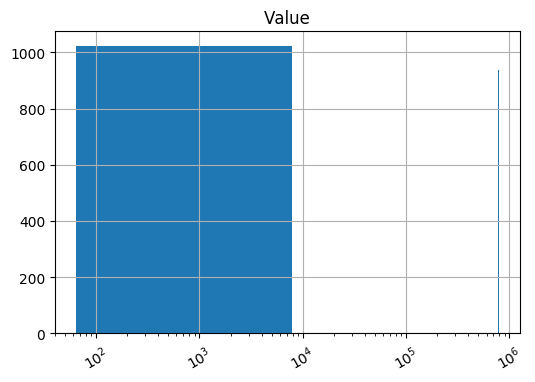

In [71]:
val = apply_inplace(ndarray_size,"Value",parseFloat)
print val.shape
print val.Value.unique()
rot = 30
bins = 100
fig, ax = plt.subplots()
val.hist(ax=ax,column="Value",xrot=rot, bins=bins)
ax.set_xscale("log")

Text(0.5,1,u'chainer_timings_k80_b64e1.log')

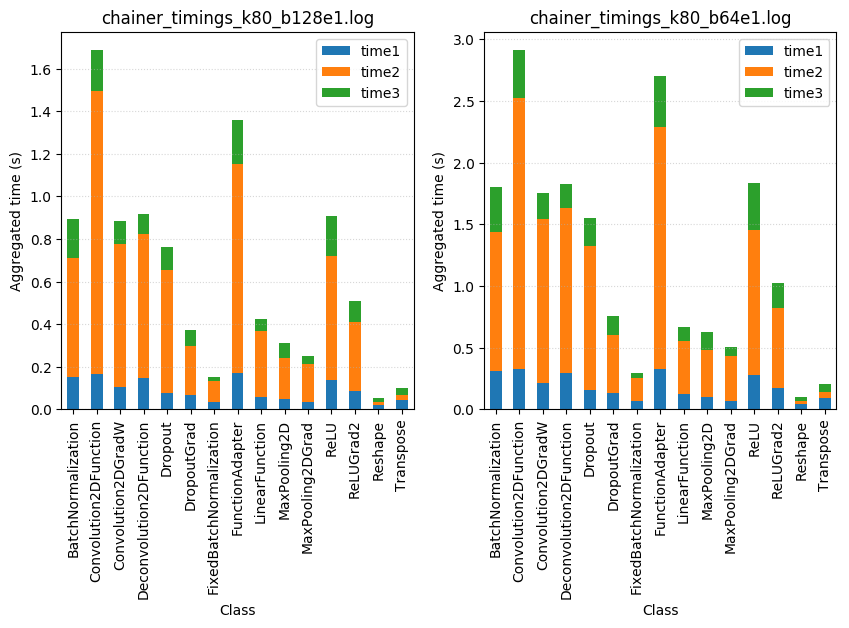

In [162]:
plt.rcParams['figure.figsize'] = 10,5 
fig, axarr = plt.subplots(1,2)
summed1.plot(kind="bar",stacked=True,ax=axarr[0])
summed2.plot(kind="bar",stacked=True,ax=axarr[1])
for ax in axarr:
    ax.yaxis.grid('on', alpha=0.5, ls=":" )
    ax.set_ylabel("Aggregated time (s)")
    
axarr[0].set_title(filename1)
axarr[1].set_title(filename2)

In [154]:
print "sum1=",summed1.sum().sum()
print "sum2=",summed2.sum().sum()

sum1= 5.947824
sum2= 11.127512
